In [118]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict

from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, uplift_by_percentile
from sklift.viz import plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve, plot_qini_curve
from sklift.viz import plot_treatment_balance_curve, plot_uplift_preds

* https://causalml.readthedocs.io/en/stable/methodology.html
* https://matheusfacure.github.io/python-causality-handbook/landing-page.html
* https://habr.com/ru/companies/glowbyte/articles/686398/
* https://habr.com/ru/companies/ru_mts/articles/485980/
* https://medium.com/grabngoinfo/multiple-treatments-uplift-models-for-binary-outcome-using-python-causalml-b2203f589a67
* https://www.robingomila.com/files/publications_pdfs/Gomila_2020_Logistic_vs_Linear.pdf

In [23]:
pd.set_option('display.max_columns', 100)

In [ ]:
# also we can manage the same with mutiple treatment -> add treatment category to the treatment variable

In [73]:
def evaluate(y_valid, uplift, treatment_valid, k=0.3):
    """
    https://www.kaggle.com/code/vanguarde/study-series-uplift-modeling
    k - top percent of observations sorted by uplift values
    """
    # by_group
    # Separately calculates conversions in top k observations in each group (control and treatment) 
    # sorted by uplift predictions. Then the difference between these conversions is calculated
    # overall
    #  the first k observations of all test data ordered by uplift prediction (overall both groups - control and treatment) 
    # and conversions in treatment and control groups calculated only on them. Then the difference between these conversions 
    # is calculated.
    upliftk = uplift_at_k(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='by_group', k=k)
    upliftk_all = uplift_at_k(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='overall', k=k)

    # Q_coef = (AUC_model - AUC_random) / (AUC_perfect - AUC_random)
    qini_coef = qini_auc_score(y_true=y_valid, uplift=uplift, treatment=treatment_valid)
    
    # AUC 
    uplift_auc = uplift_auc_score(y_true=y_valid, uplift=uplift, treatment=treatment_valid)

    wau = weighted_average_uplift(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='by_group')
    wau_all = weighted_average_uplift(y_true=y_valid, uplift=uplift, treatment=treatment_valid)

    print(f'uplift at top {int(k*100)}% by group: {upliftk:.2f} by overall: {upliftk_all:.2f}\n',
          f'Weighted average uplift by group: {wau:.2f} by overall: {wau_all:.2f}\n',
          f'AUUC by group: {uplift_auc:.2f}\n',
          f'AUQC by group: {qini_coef:.2f}\n')
    return {f'uplift@{int(k*100)}': upliftk, f'uplift@{int(k*100)}_all': upliftk_all, 'AUQC': qini_coef, 'AUUC': uplift_auc, 
            'WAU': wau, 'WAU_all': wau_all}

plot_types = ['uplift_curve', 'uplift_perc_group', 'uplift_perc_overall', 'qini_curve', 'treatment_bal', 'pred_tr_vs_cnt']

def get_plots(response, uplift, treatment, plot_type='upl_perc', treatment_pred=None, control_pred=None):
    """
    treatment_pred: predictions for all observations if they are treatment.
    control_pred: predictions for all observations if they are control.
    """
    if plot_type == 'uplift_curve':
        plot_uplift_curve(response, uplift, treatment, perfect=False)
    elif plot_type == 'uplift_perc_group':
        plot_uplift_by_percentile(response, uplift, treatment, strategy='by_group', kind='bar')
    elif plot_type == 'uplift_perc_overall':
        plot_uplift_by_percentile(response, uplift, treatment, strategy='overall', kind='bar')
    elif plot_type == 'qini_curve':
        plot_qini_curve(response, uplift, treatment, perfect=False)
    elif plot_type == 'treatment_bal':
        plot_treatment_balance_curve(uplift, treatment, random=True, winsize=0.1)
    elif plot_type == 'pred_tr_vs_cnt':
        if treatment_pred is not None and control_pred is not None:
            plot_uplift_preds(treatment_pred, control_pred, log=False, bins=100)

In [27]:
train = pd.read_csv('megafon/train.csv', index_col='id')
test = pd.read_csv('megafon/test.csv', index_col='id')

In [28]:
train.head()

,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [29]:
train.conversion.value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [30]:
train.groupby('treatment_group')['conversion'].mean()

treatment_group
control      0.179400
treatment    0.228919
Name: conversion, dtype: float64

In [31]:
train.isna().sum().sum()

0

In [32]:
train.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,19.093492,-0.093886,-0.002533,-2.463280,13.161988,7.063375,6.858253,-0.020896,-0.985809,-1.114770,14.835209,-9.909231,0.002470,-0.002707,11.159296,0.024798,-0.978981,4.599121,-6.263516,0.000554,2.704003,0.027546,-6.514740,-0.005655,3.002134,5.325791,7.739900,-4.721989,-9.206852,2.728692,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456,0.204190
std,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,455.894665,11.295157,56.797326,39.922589,114.277207,77.628539,190.951808,11.476030,26.239683,72.371005,138.517373,160.879307,0.999777,1.000431,104.195126,28.332643,13.729246,142.981246,75.071084,1.000134,51.108902,107.851987,153.130771,6.964937,47.529482,70.700510,134.675174,131.789351,197.493595,39.501936,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662,0.403109
min,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,-2289.294108,-52.074964,-313.255431,-195.457350,-636.553079,-533.404670,-913.011610,-55.140610,-125.733156,-330.755792,-770.324798,-774.266979,-4.545333,-4.708793,-579.451426,-126.515623,-64.651485,-732.116727,-399.414460,-4.553086,-346.728398,-515.521884,-743.800243,-32.088261,-251.277376,-348.076864,-668.793144,-700.110808,-1016.301591,-179.589370,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323,0.000000
25%,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,-286.292508,-7.613948,-38.401625,-29.205585,-62.727814,-36.893267,-121.868113,-7.752689,-18.645383,-50.050451,-77.058591,-117.394644,-0.671963,-0.676781,-57.964784,-19.118055,-10.247693,-91.190920,-56.366783,-0.674265,-30.975631,-72.732677,-109.888686,-4.711524,-26.971012,-42.250017,-82.922581,-93.661192,-142.413854,-23.338528,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688,0.000000
50%,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,17.651122,-0.092166,-0.011893,-2.438805,13.426780,6.988854,6.639970,-0.030727,-1.007271,-1.084433,15.207025,-9.837197,0.001802,-0.003722,11.438983,0.023834,-0.946478,4.772537,-6.364402,-0.000372,2.732262,0.114877,-6.661874,-0.000436,2.966662,5.500324,7.516796,-4.835168,-9.003721,2.779691,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895,0.000000
75%,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,324.226048,7.409305,38.291691,24.248160,89.130548,50.993029,135.756702,7.731675,16.690977,47.694238,106.788310,97.891879,0.677217,0.671145,80.327985,19.116412,8.309784,100.845315,43.792144,0.675415,36.369149,72.890914,96.255945,4.690724,32.898

In [36]:
x_train, x_test = train_test_split(train, test_size=0.2, shuffle=True, 
                                   stratify=train[['conversion', 'treatment_group']], random_state=42)

In [39]:
train_outcome = x_train['conversion']
train_treatment = x_train['treatment_group']
features = [c for c in x_train.columns if c.startswith('X_')]
train_data = x_train[features]

test_outcome = x_test['conversion']
test_treatment = x_test['treatment_group']
test_data = x_test[features]

In [43]:
s_learner = BaseSClassifier(LGBMClassifier(), control_name='control')

ate, lb, ub = s_learner.estimate_ate(X=train[features], treatment=train.treatment_group, y=train.conversion, return_ci=True,
                                     n_bootstraps=100, bootstrap_size=500)

print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:.2f})'.format(ate[0], lb[0], ub[0]))

Average Treatment Effect for treatment 1: 0.05 (0.05, 0.05)


In [44]:
s_learner.fit(train_data, train_treatment, train_outcome)

In [47]:
cate_train = s_learner.predict(train_data, train_treatment)
cate_test = s_learner.predict(test_data, test_treatment)

In [51]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.41 by overall: 0.41
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.23



{'uplift@10': 0.41195635576918155,
 'uplift@10_all': 0.414472458906944,
 'AUQC': 0.23484406838387215,
 'AUUC': 0.16217950258718958,
 'WAU': 0.049517163272342055,
 'WAU_all': 0.04998736627011744}

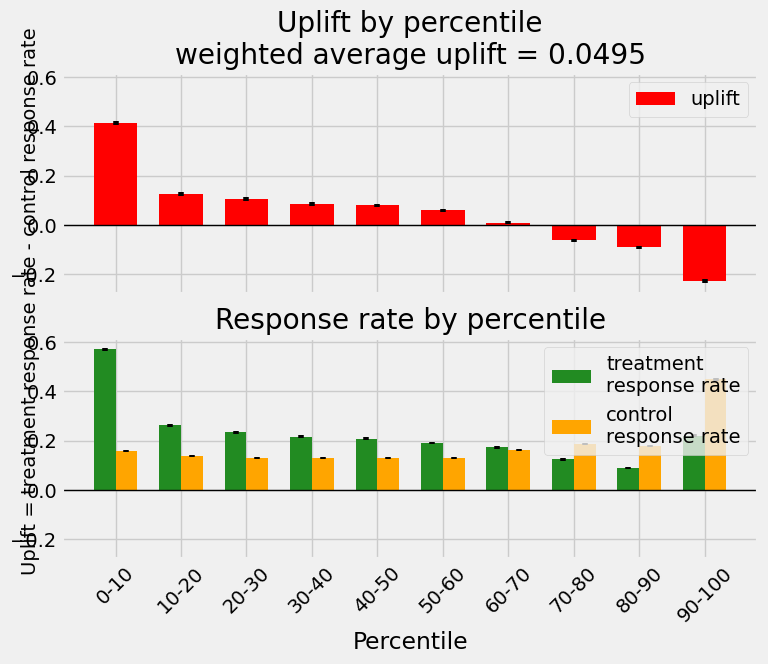

In [74]:
get_plots(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), plot_type='uplift_perc_group')

In [76]:
t_learner = BaseTClassifier(LGBMClassifier(), control_name='control')

ate, lb, ub = t_learner.estimate_ate(X=train[features], treatment=train.treatment_group, y=train.conversion)

print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:.2f})'.format(ate[0], lb[0], ub[0]))

Average Treatment Effect for treatment: 0.05 (0.05, 0.05)


In [77]:
t_learner.fit(train_data, train_treatment, train_outcome)

In [78]:
cate_train = t_learner.predict(train_data, train_treatment)
cate_test = t_learner.predict(test_data, test_treatment)

In [79]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.45 by overall: 0.45
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.17
 AUQC by group: 0.24



{'uplift@10': 0.44830652623119044,
 'uplift@10_all': 0.4536037974390936,
 'AUQC': 0.24353736432394124,
 'AUUC': 0.16882773260995687,
 'WAU': 0.049516871504881536,
 'WAU_all': 0.0504957731914246}

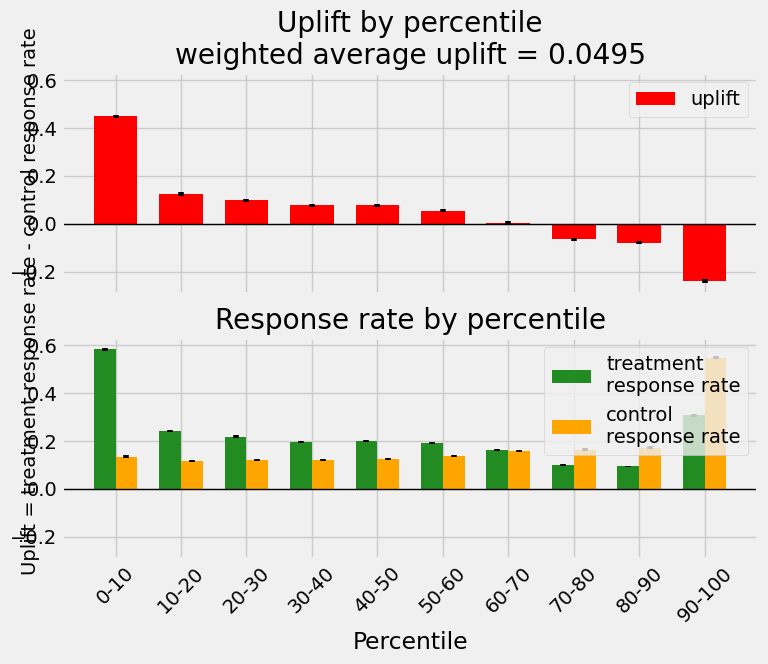

In [80]:
get_plots(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), plot_type='uplift_perc_group')

```
# ITE (CATE) with confidence interval
x_learner_ite, x_learner_ite_lb, x_learner_ite_ub = x_learner.fit_predict(X=X, treatment=treatment, y=y_binary, return_ci=True,
                               n_bootstraps=100, bootstrap_size=500)
```

### using propensity score

In [81]:
# LogisticRegression for propensity-score weightening as default
x_learner = BaseXClassifier(treatment_outcome_learner=LGBMClassifier(), 
                            treatment_effect_learner=LGBMRegressor(),
                            control_outcome_learner=LGBMClassifier(),
                            control_effect_learner=LGBMRegressor(),
                            control_name='control')

In [ ]:
ate, lb, ub = x_learner.estimate_ate(X=train[features], treatment=train.treatment_group, y=train.conversion)

print('Average Treatment Effect for treatment: {:.2f} ({:.2f}, {:.2f})'.format(ate[0], lb[0], ub[0]))

In [ ]:
x_learner.fit(train_data, train_treatment, train_outcome)

In [ ]:
cate_train = x_learner.predict(train_data, train_treatment)
cate_test = x_learner.predict(test_data, test_treatment)

In [ ]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

In [ ]:
get_plots(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), plot_type='uplift_perc_group')

In [ ]:
# R-learner with CV estimation

In [ ]:
r_learner = BaseRClassifier(outcome_learner=LGBMClassifier(), effect_learner=LGBMRegressor())
r_learner.fit(train_data, train_treatment.map({'treatment': 1, 'control': 0}), train_outcome)

In [ ]:
cate_train = r_learner.predict(train_data, train_treatment)
cate_test = r_learner.predict(test_data, test_treatment)

#### using orthogonalization by using residuals of treatment and outcome: 3 models, final = cate ~ X, resid_t, resid_out

In [108]:
from econml.dml import NonParamDML  # orthogonalization
from econml.dr import DRLearner  # propensity score
from econml.metalearners import XLearner  # propensity score

In [87]:
est1 = NonParamDML(
    model_y=LGBMRegressor(),  # default
    model_t=LGBMRegressor(),
    model_final=LGBMRegressor(),
    discrete_treatment=True
)
est1.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data, W=None)

AttributeError: 'LGBMRegressor' object has no attribute 'predict_proba'

In [88]:
est2 = NonParamDML(
    model_y=LGBMClassifier(),  # not recommended, but the outcome is binary
    model_t=LGBMClassifier(),  # not recommended, but the treatment is binary
    model_final=LGBMRegressor(),
    discrete_treatment=True
)
est2.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data, W=None)

In [92]:
est3 = NonParamDML(
    model_y=LGBMRegressor(),  
    model_t=LGBMClassifier(),  # not recommended, but the treatment is binary
    model_final=LGBMRegressor(),
    discrete_treatment=True
)
est3.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data, W=None)

In [96]:
cate_train = est2.effect(train_data)
cate_test = est2.effect(test_data)

In [97]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.46 by overall: 0.45
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.18
 AUQC by group: 0.26



{'uplift@10': 0.4589951670309098,
 'uplift@10_all': 0.4506058659962503,
 'AUQC': 0.264879869050263,
 'AUUC': 0.17991445310296103,
 'WAU': 0.04951893935307181,
 'WAU_all': 0.05052338855181254}

In [90]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.42 by overall: 0.42
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.23



{'uplift@10': 0.42047437202213794,
 'uplift@10_all': 0.42225752973772807,
 'AUQC': 0.23229016412781534,
 'AUUC': 0.16081164988323396,
 'WAU': 0.04951840697165767,
 'WAU_all': 0.04939268338008468}

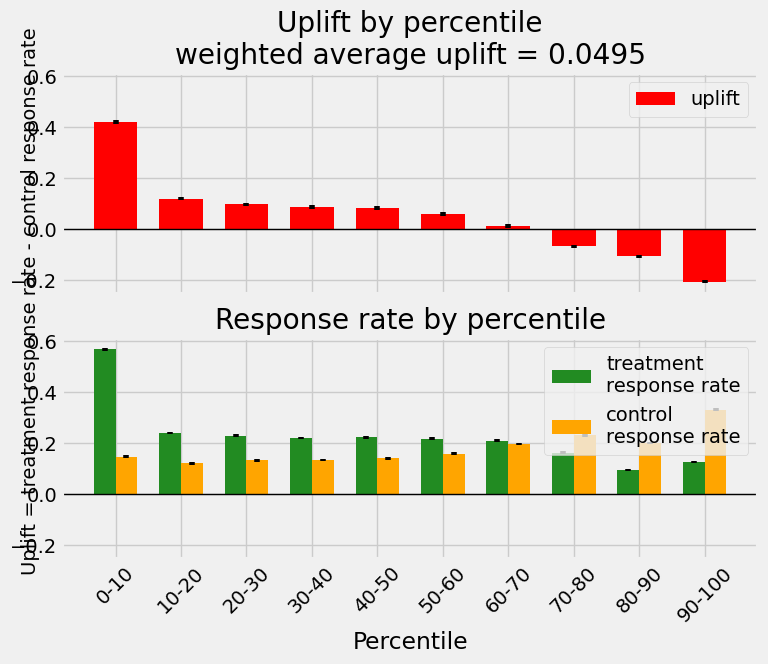

In [91]:
get_plots(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), plot_type='uplift_perc_group')

In [93]:
cate_train = est3.effect(train_data)
cate_test = est3.effect(test_data)

In [95]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.47 by overall: 0.47
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.19
 AUQC by group: 0.27



{'uplift@10': 0.4683226652511888,
 'uplift@10_all': 0.46851846692707605,
 'AUQC': 0.27082466654809884,
 'AUUC': 0.1866232126350142,
 'WAU': 0.04951893919539078,
 'WAU_all': 0.04955579469782811}

In [94]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.43 by overall: 0.43
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.428138355718951,
 'uplift@10_all': 0.4294954764629978,
 'AUQC': 0.236839255287289,
 'AUUC': 0.16388030261764258,
 'WAU': 0.049518236520251294,
 'WAU_all': 0.0493690026811125}

In [129]:
debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()

num_train_treat = train_treatment.map({'treatment': 1, 'control': 0})

treatment_resriduals = num_train_treat - cross_val_predict(debias_m, train_data, num_train_treat, cv=5, method='predict')
outcome_residuals =  train_outcome - cross_val_predict(denoise_m, train_data, train_outcome, cv=5, method='predict')

model_final = LGBMRegressor()
 
# create the weights
w = treatment_resriduals ** 2 
 
# create the transformed target
y_star = (outcome_residuals / treatment_resriduals)
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train_data, y=y_star, sample_weight=w)

LGBMRegressor()

In [130]:
cate_train = model_final.predict(train_data)
cate_test = model_final.predict(test_data)

In [131]:
evaluate(train_outcome, cate_train, train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.47 by overall: 0.47
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.19
 AUQC by group: 0.27



{'uplift@10': 0.4740602966659342,
 'uplift@10_all': 0.47497555820026127,
 'AUQC': 0.2725548331228039,
 'AUUC': 0.1880555537240107,
 'WAU': 0.04951893917616139,
 'WAU_all': 0.049491358855151796}

In [132]:
evaluate(test_outcome, cate_test, test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.43 by overall: 0.43
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.43096171956037943,
 'uplift@10_all': 0.4319579307151486,
 'AUQC': 0.2381263236837833,
 'AUUC': 0.16477339623359497,
 'WAU': 0.04951818936985683,
 'WAU_all': 0.04958460473010923}

In [134]:
debias_m = LGBMClassifier()
denoise_m = LGBMClassifier()

treatment_resriduals = num_train_treat - cross_val_predict(debias_m, train_data, num_train_treat, cv=5, method='predict_proba')[:,1]
outcome_residuals =  train_outcome - cross_val_predict(denoise_m, train_data, train_outcome, cv=5, method='predict_proba')[:,1]

model_final = LGBMRegressor()
 
# create the weights
w = treatment_resriduals ** 2 
 
# create the transformed target
y_star = (outcome_residuals / treatment_resriduals)
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train_data, y=y_star, sample_weight=w)

LGBMRegressor()

In [135]:
cate_train = model_final.predict(train_data)
cate_test = model_final.predict(test_data)

In [136]:
evaluate(train_outcome, cate_train, train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.47 by overall: 0.47
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.19
 AUQC by group: 0.27



{'uplift@10': 0.4693647137160245,
 'uplift@10_all': 0.4710988596695433,
 'AUQC': 0.269783511303698,
 'AUUC': 0.18616784296322228,
 'WAU': 0.049518939101380416,
 'WAU_all': 0.049410414189650476}

In [137]:
evaluate(test_outcome, cate_test, test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.43 by overall: 0.44
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.43263602899421083,
 'uplift@10_all': 0.43767544481581266,
 'AUQC': 0.23773889301698808,
 'AUUC': 0.16462861893041283,
 'WAU': 0.04951804721638224,
 'WAU_all': 0.049330993466139145}

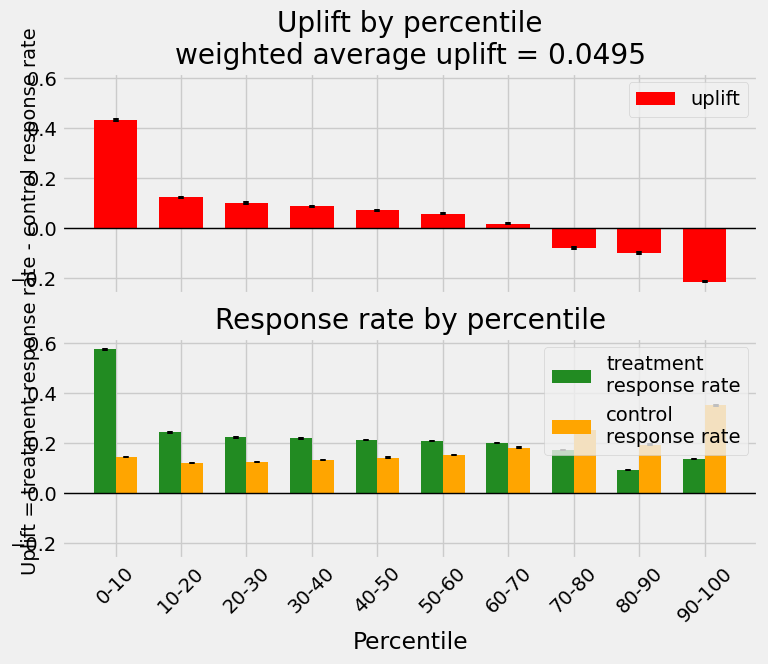

In [138]:
get_plots(test_outcome, cate_test, test_treatment.map({'treatment': 1, 'control': 0}), plot_type='uplift_perc_group')

In [139]:
def logistic_residuals(y_true, y_pred, eps=1e-10):
    y_pred = np.clip(y_pred, a_min=eps, a_max=1-eps)
    log_loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return log_loss

In [140]:
debias_m = LGBMClassifier()
denoise_m = LGBMClassifier()

treatment_resriduals = logistic_residuals(num_train_treat, 
                                          cross_val_predict(debias_m, 
                                                            train_data, 
                                                            num_train_treat, cv=5, method='predict_proba')[:,1])
outcome_residuals = logistic_residuals(train_outcome, cross_val_predict(denoise_m, 
                                                                        train_data, 
                                                                        train_outcome, cv=5, method='predict_proba')[:,1])

model_final = LGBMRegressor()
 
# create the weights
w = treatment_resriduals ** 2 
 
# create the transformed target
y_star = (outcome_residuals / treatment_resriduals)
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train_data, y=y_star, sample_weight=w)

LGBMRegressor()

In [141]:
cate_train = model_final.predict(train_data)
cate_test = model_final.predict(test_data)

In [142]:
evaluate(train_outcome, cate_train, train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.25 by overall: 0.24
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.09
 AUQC by group: 0.13



{'uplift@10': 0.24716291830169818,
 'uplift@10_all': 0.24369147352636727,
 'AUQC': 0.13246952709962,
 'AUUC': 0.09084704586070116,
 'WAU': 0.049518945679115224,
 'WAU_all': 0.04843049827312025}

In [143]:
evaluate(test_outcome, cate_test, test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.25 by overall: 0.25
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.09
 AUQC by group: 0.13



{'uplift@10': 0.25088992748335665,
 'uplift@10_all': 0.2518100359791917,
 'AUQC': 0.12945742544531166,
 'AUUC': 0.08942503633838225,
 'WAU': 0.04951639901541135,
 'WAU_all': 0.049974910982753716}

### DRLearner (Doubly Robust) - it is enough to get fine estimates rather by propensity model or outcome model

In [104]:
est = DRLearner(model_propensity=LogisticRegression(), 
                model_regression=LGBMRegressor(),  # LGBMClassifier(),
                model_final=LGBMRegressor())
est.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data, W=None)

In [105]:
cate_train = est.effect(train_data)
cate_test = est.effect(test_data)

In [106]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.47 by overall: 0.47
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.19
 AUQC by group: 0.27



{'uplift@10': 0.46594684392015323,
 'uplift@10_all': 0.4667838048647195,
 'AUQC': 0.27191764337357466,
 'AUUC': 0.18751887782388432,
 'WAU': 0.04951893919795472,
 'WAU_all': 0.04961856541576606}

In [107]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.43 by overall: 0.43
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.42897071796299957,
 'uplift@10_all': 0.43255658899223254,
 'AUQC': 0.23656438862495024,
 'AUUC': 0.16374610936290102,
 'WAU': 0.04951822848631804,
 'WAU_all': 0.049610144435328934}

In [109]:
x_learner = XLearner(models=LGBMClassifier(), 
                     cate_models=LGBMRegressor(), 
                     propensity_model=LogisticRegression())
x_learner.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data)

In [110]:
cate_train = x_learner.effect(train_data)
cate_test = x_learner.effect(test_data)

In [111]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.44 by overall: 0.44
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.17
 AUQC by group: 0.25



{'uplift@10': 0.4361210387677676,
 'uplift@10_all': 0.43735371794925126,
 'AUQC': 0.2506181358611399,
 'AUUC': 0.17304738819858287,
 'WAU': 0.04951893895694629,
 'WAU_all': 0.049172393697148646}

In [112]:
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.42 by overall: 0.42
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.4213029836352471,
 'uplift@10_all': 0.4248776376540969,
 'AUQC': 0.2373898132117806,
 'AUUC': 0.16397249266016897,
 'WAU': 0.04951699687429169,
 'WAU_all': 0.049613432409880656}

In [144]:
x_learner = XLearner(models=LGBMRegressor(), 
                     cate_models=LGBMRegressor(), 
                     propensity_model=LogisticRegression())
x_learner.fit(train_outcome, train_treatment.map({'treatment': 1, 'control': 0}), X=train_data)

In [145]:
cate_train = x_learner.effect(train_data)
cate_test = x_learner.effect(test_data)

In [146]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)
print('-'*100)
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.44 by overall: 0.45
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.17
 AUQC by group: 0.25

----------------------------------------------------------------------------------------------------
uplift at top 10% by group: 0.42 by overall: 0.42
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



{'uplift@10': 0.41966159640632883,
 'uplift@10_all': 0.4227448639475587,
 'AUQC': 0.2357813429799817,
 'AUUC': 0.16304826354354826,
 'WAU': 0.049517606617422556,
 'WAU_all': 0.04958456544142307}

#### https://arxiv.org/pdf/2310.05549.pdf

In [149]:
p = cross_val_predict(LogisticRegression(), train_data, num_train_treat, cv=5, method='predict_proba')[:,1]
cate_estimator = LGBMRegressor()
C = np.mean(train_outcome)  # constant that lies in (0, 1)

transformed_target = (train_outcome - C) * ((num_train_treat - p) / (p * (1 - p)))

cate_estimator.fit(train_data, transformed_target)

LGBMRegressor()

In [150]:
cate_train = cate_estimator.predict(train_data)
cate_test = cate_estimator.predict(test_data)

In [151]:
evaluate(train_outcome, cate_train.flatten(), train_treatment.map({'treatment': 1, 'control': 0}), k=0.1)
print('-'*100)
evaluate(test_outcome, cate_test.flatten(), test_treatment.map({'treatment': 1, 'control': 0}), k=0.1)

uplift at top 10% by group: 0.48 by overall: 0.48
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.20
 AUQC by group: 0.29

----------------------------------------------------------------------------------------------------
uplift at top 10% by group: 0.42 by overall: 0.42
 Weighted average uplift by group: 0.05 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.23



{'uplift@10': 0.4194476159656191,
 'uplift@10_all': 0.42317513157781783,
 'AUQC': 0.23286385438685805,
 'AUUC': 0.16120505415924427,
 'WAU': 0.04951858036758798,
 'WAU_all': 0.04950928404738948}